In [1]:
import sys
import numpy as np
import os
import pandas
from ipynb.fs.full.clean_gadget import clean_gadget
from ipynb.fs.full.vectorize_gadget import GadgetVectorizer


import warnings
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight

warnings.filterwarnings("ignore")

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, LeakyReLU
from keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
import sklearn.model_selection as model_selection


In [2]:
class LSTM_MODEL:
    def __init__(self, data, name="", batch_size=""):
        vectors = np.stack(data.iloc[:, 1].values)
        labels = data.iloc[:, 0].values
        positive_idxs = np.where(labels == 1)[0]
        negative_idxs = np.where(labels == 0)[0]
        undersampled_negative_idxs = np.random.choice(negative_idxs, len(positive_idxs), replace=False)
        resampled_idxs = np.concatenate([positive_idxs, undersampled_negative_idxs])
        X_train, X_test, y_train, y_test = train_test_split(vectors[resampled_idxs, ], labels[resampled_idxs],test_size=0.2, stratify=labels[resampled_idxs])
        
        print("\n\ndata: ",data)
        print("\n\nvectors: ",vectors)
        print("\n\n\nlabels: ",str(set(labels)))
        print("shape of input - training set", X_train.shape)
        print("shape of output - training set", y_train.shape)
        print("shape of input - testing set", X_test.shape)
        print("shape of output - testing set", y_test.shape)
        print('\n\n\n\n')

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = to_categorical(y_train)
        self.y_test = to_categorical(y_test)
        self.name = name
        self.batch_size = batch_size
        
        
        model = Sequential()

        model.add(LSTM(units = 300, return_sequences = True, input_shape = (50,50)))
        model.add(Dropout(0.2))

        model.add(LSTM(units = 300, return_sequences = True))
        model.add(Dropout(0.2))

        model.add(LSTM(units = 200, return_sequences = True))
        model.add(Dropout(0.2))

        model.add(LSTM(units = 100))
        model.add(Dropout(0.2))

        model.add(Dense(units = 2))

        model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
        self.model = model


    """
    Trains model based on training data
    """
    def train(self,epochs=""):
        self.model.fit(self.X_train, self.y_train, batch_size=self.batch_size,epochs=epochs)
        # , class_weight=self.class_weight)
        self.model.save_weights(self.name + "_model.h5")

    """
    Tests accuracy of model based on test data
    Loads weights from file if no weights are attached to model object
    """
    def test(self):
        print('\n\nTesting Model *****')
        self.model.load_weights(self.name + "_model.h5")
        values = self.model.evaluate(self.X_test, self.y_test, batch_size=self.batch_size)
        print("\nAccuracy is...", values[1])
        predictions = (self.model.predict(self.X_test, batch_size=self.batch_size)).round()

        tn, fp, fn, tp = confusion_matrix(np.argmax(self.y_test, axis=1), np.argmax(predictions, axis=1)).ravel()
        
        print("Confusion Matrix : ")
        print(f"[{tp}] [{fp}]")
        print(f"[{fn}] [{tn}]")
        
        data = [[tp, fp],[fn, tn]]
        heatmap = plt.pcolor(data)
        plt.colorbar(heatmap)
        plt.show()

        print('\nFalse positive rate is :', fp / (fp + tn))
        print('\nFalse negative rate is :', fn / (fn + tp))
        recall = tp / (tp + fn)
        print('\nTrue positive rate is  :', recall)
        precision = tp / (tp + fp)
        print('\nPrecision is: ', precision)
        print('\nF1 score is : ', (2 * precision * recall) / (precision + recall))
        


In [3]:
"""
Parses gadget file to find individual gadgets
Yields each gadget as list of strings, where each element is code line
Has to ignore first line of each gadget, which starts as integer+space
At the end of each code gadget is binary value
    This indicates whether or not there is vulnerability in that gadget
"""
def parse_file(filename):
    with open(filename, "r", encoding="utf8") as file:
        gadget = []
        gadget_val = 0
        for line in file:
            stripped = line.strip()
            if not stripped:
                continue
            if "-" * 33 in line and gadget: 
                yield clean_gadget(gadget), gadget_val
                gadget = []
            elif stripped.split()[0].isdigit():
                if gadget:
                    # Code line could start with number (somehow)
                    if stripped.isdigit():
                        gadget_val = int(stripped)
                    else:
                        gadget.append(stripped)
            else:
                gadget.append(stripped)

In [4]:
"""
Uses gadget file parser to get gadgets and vulnerability indicators
Assuming all gadgets can fit in memory, build list of gadget dictionaries
    Dictionary contains gadgets and vulnerability indicator
    Add each gadget to GadgetVectorizer
Train GadgetVectorizer model, prepare for vectorization
Loop again through list of gadgets
    Vectorize each gadget and put vector into new list
Convert list of dictionaries to dataframe when all gadgets are processed
"""
def get_vectors_df(filename, vector_length=100):
    gadgets = []
    count = 0
    vectorizer = GadgetVectorizer(vector_length)
    for gadget, val in parse_file(filename):
        count += 1
        print("Collecting gadgets...", count, end="\r")
        vectorizer.add_gadget(gadget)
        row = {"gadget" : gadget, "val" : val}
        gadgets.append(row)
    print('Found {} forward slices and {} backward slices'
          .format(vectorizer.forward_slices, vectorizer.backward_slices))
    print()
    print("Training model...", end="\r")
    vectorizer.train_model()
    print()
    vectors = []
    count = 0
    for gadget in gadgets:
        count += 1
        print("Processing gadgets...", count, end="\r")
        vector = vectorizer.vectorize(gadget["gadget"])
        row = {"vector" : vector, "val" : gadget["val"]}
        vectors.append(row)
    print()
    df = pandas.DataFrame(vectors)
    return df

In [5]:
            
"""
Gets filename, either loads vector DataFrame if exists or creates it if not
Instantiate neural network, pass data to it, train, test, print accuracy
"""
def main():
    filename = input('Enter dataset file path : ')
    epochs = int(input('Enter no of epochs : '))
    batch = int(input('Enter no of batch size : '))
  
    parse_file(filename)
    base = os.path.splitext(os.path.basename(filename))[0]
    vector_filename = base + "_gadget_vectors.pkl"
    print('Vector FileName : '+vector_filename)
    vector_length = 50
    if os.path.exists(vector_filename):
        df = pandas.read_pickle(vector_filename)
    else:
        df = get_vectors_df(filename, vector_length)
        df.to_pickle(vector_filename)
    lstm = LSTM_MODEL(df, batch_size=batch)
    print('\nTraining Model')
    lstm.train(epochs)
    lstm.test()


Enter dataset file path : C:\Users\61450\Downloads\vd\cwe399_cgd.txt
Enter no of epochs : 4
Enter no of batch size : 128
Vector FileName : cwe399_cgd_gadget_vectors.pkl
Found 13697 forward slices and 8188 backward slices3732 17309

Training model...
Processing gadgets... 21885958316077 19249


data:         val                                             vector
0        0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1        0  [[0.030640723183751106, -0.04113559424877167, ...
2        0  [[0.030640723183751106, -0.04113559424877167, ...
3        0  [[0.0333654023706913, -0.03634626418352127, -0...
4        0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5        0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6        0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
7        0  [[0.13356232643127441, -0.15786238014698029, -...
8        0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
9        0  [[0.21021366119384766, -0.6237104535102844, -0...
10       0  [[0.

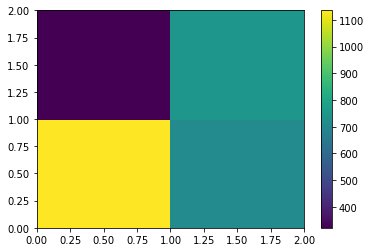


False positive rate is : 0.48592999313658203

False negative rate is : 0.22031571722717913

True positive rate is  : 0.7796842827728209

Precision is:  0.6160520607375272

F1 score is :  0.6882762799151773


In [6]:
if __name__ == "__main__":
    main()

Enter dataset file path : C:\Users\61450\Downloads\vd\cwe119_cgd.txt
Enter no of epochs : 4
Enter no of batch size : 128
Vector FileName : cwe119_cgd_gadget_vectors.pkl
Found 23730 forward slices and 16023 backward slices0678 12466 13287 16584 17735 228472381325606 27454 28619 298013050931711 33921 37210

Training model...
Processing gadgets... 39753452


data:         val                                             vector
0        0  [[0.059894729405641556, 0.029224473983049393, ...
1        0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2        0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3        0  [[0.14042708277702332, -0.11144398897886276, 0...
4        0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5        0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6        0  [[-0.10960769653320312, 0.0578172504901886, 0....
7        0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
8        0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
9        0  [[-

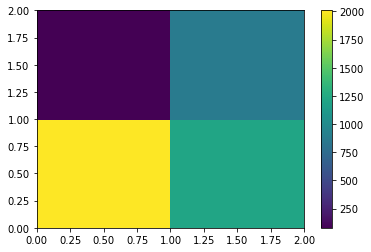


False positive rate is : 0.5795019157088123

False negative rate is : 0.037835249042145594

True positive rate is  : 0.9621647509578544

Precision is:  0.6241068654861758

F1 score is :  0.7571132466553608


In [7]:
if __name__ == "__main__":
    main()